In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import eigh
from scipy.signal import find_peaks
from scipy.integrate import simps
from scipy.interpolate import UnivariateSpline
from scipy.ndimage import gaussian_filter1d

from collections import Counter
from itertools import product
from collections import namedtuple

from multiprocessing import Pool
from tqdm.notebook import tqdm

import cvxpy as cp

import os

from datetime import datetime

A utility to get filenames time-date stamped

In [2]:
def get_unique_filename(fname):
    return fname.format(
        datetime.now().strftime("_%m-%d_%H-%M")
    )

# Loading and pre-processing pulses

Load pulses. Note that each pulse has its own time axis

In [3]:
folder_data = "experimental data 02-04-2022"

os.listdir(folder_data)

['export_SO_F07_x.txt',
 'export_SO_short_N2_night_x.txt',
 'export_SO_long_N2_night_x.txt',
 'export_SO_short_N0_night_x.txt',
 'export_SO_F05_x.txt',
 'export_SO_short_N1_night_x.txt',
 'export_SO_long_N1_night_x.txt',
 'export_SO_F06_x.txt',
 'export_SO_new_short_N0_night_x.txt',
 'export_SO_long_N0_night_x.txt',
 'export_SO_new_long_N0_night_x.txt',
 '_export_SO_long_N0_night_x.txt',
 'export_SO_F08_x.txt']

## Loading "pure" pulses

In [34]:
pulses = {}

# declare type
Pulse = namedtuple('Pulse', ['time', 'field', 'interp_field', 'peaks_time', 'half_period'])

# save index where the field reseaches its maximum
maxima_position = {}

for freq in range(5, 9):
    data = np.loadtxt(
        folder_data + '/export_SO_F0{}_x.txt'.format(freq)
    )
    time, field = data.T
    
    # check that time is time
    assert np.all(np.diff(time) > 0), "`time` is probably not time"
    
    label = '0.{} THz'.format(freq)
    
    # Relabel time axis such that peak field is at zero time 
    abs_field = np.abs(field)
    indx = abs_field.argmax()
    maxima_position[label] = indx
    #time -= time[indx] 
    
    
    # Extract information for the combinatorial method     
    ampl_threshold = 0.5 * abs_field.max()
    
    indx = find_peaks(abs_field, height=ampl_threshold)[0]
    peaks_time = time[indx[1:-1]]
    
    half_period = Counter(np.diff(peaks_time)).most_common(1)[0][0]
    
    #peaks_time = time[indx[1]:indx[-2]]
    
    
    # interpolating the pulse
    interp_field = UnivariateSpline(time, field, ext='zeros', k=4, s=0)
    
    # finding the extrema analytically
    extrema = interp_field.derivative().roots()
    
    # Selecting extrema that are above the amplitude threshold 
    extrema = extrema[np.abs(interp_field(extrema)) >= ampl_threshold][1:-1]
    
    # There is 2 decimal precision in the experiment 
    extrema = np.unique(np.round(extrema, 2))
    
    # Saving the data 
    pulses[label] = Pulse(
        time, 
        field, 
        UnivariateSpline(time, gaussian_filter1d(field, 1), ext='zeros', k=3, s=0),
        peaks_time,
        half_period,
    )
    
# saving the largest frequency
largest_freq = label

 Checking whether the time axis coincide

In [35]:
same_time_axis = all(np.allclose(time, data.time) for data in pulses.values())
same_time_axis

True

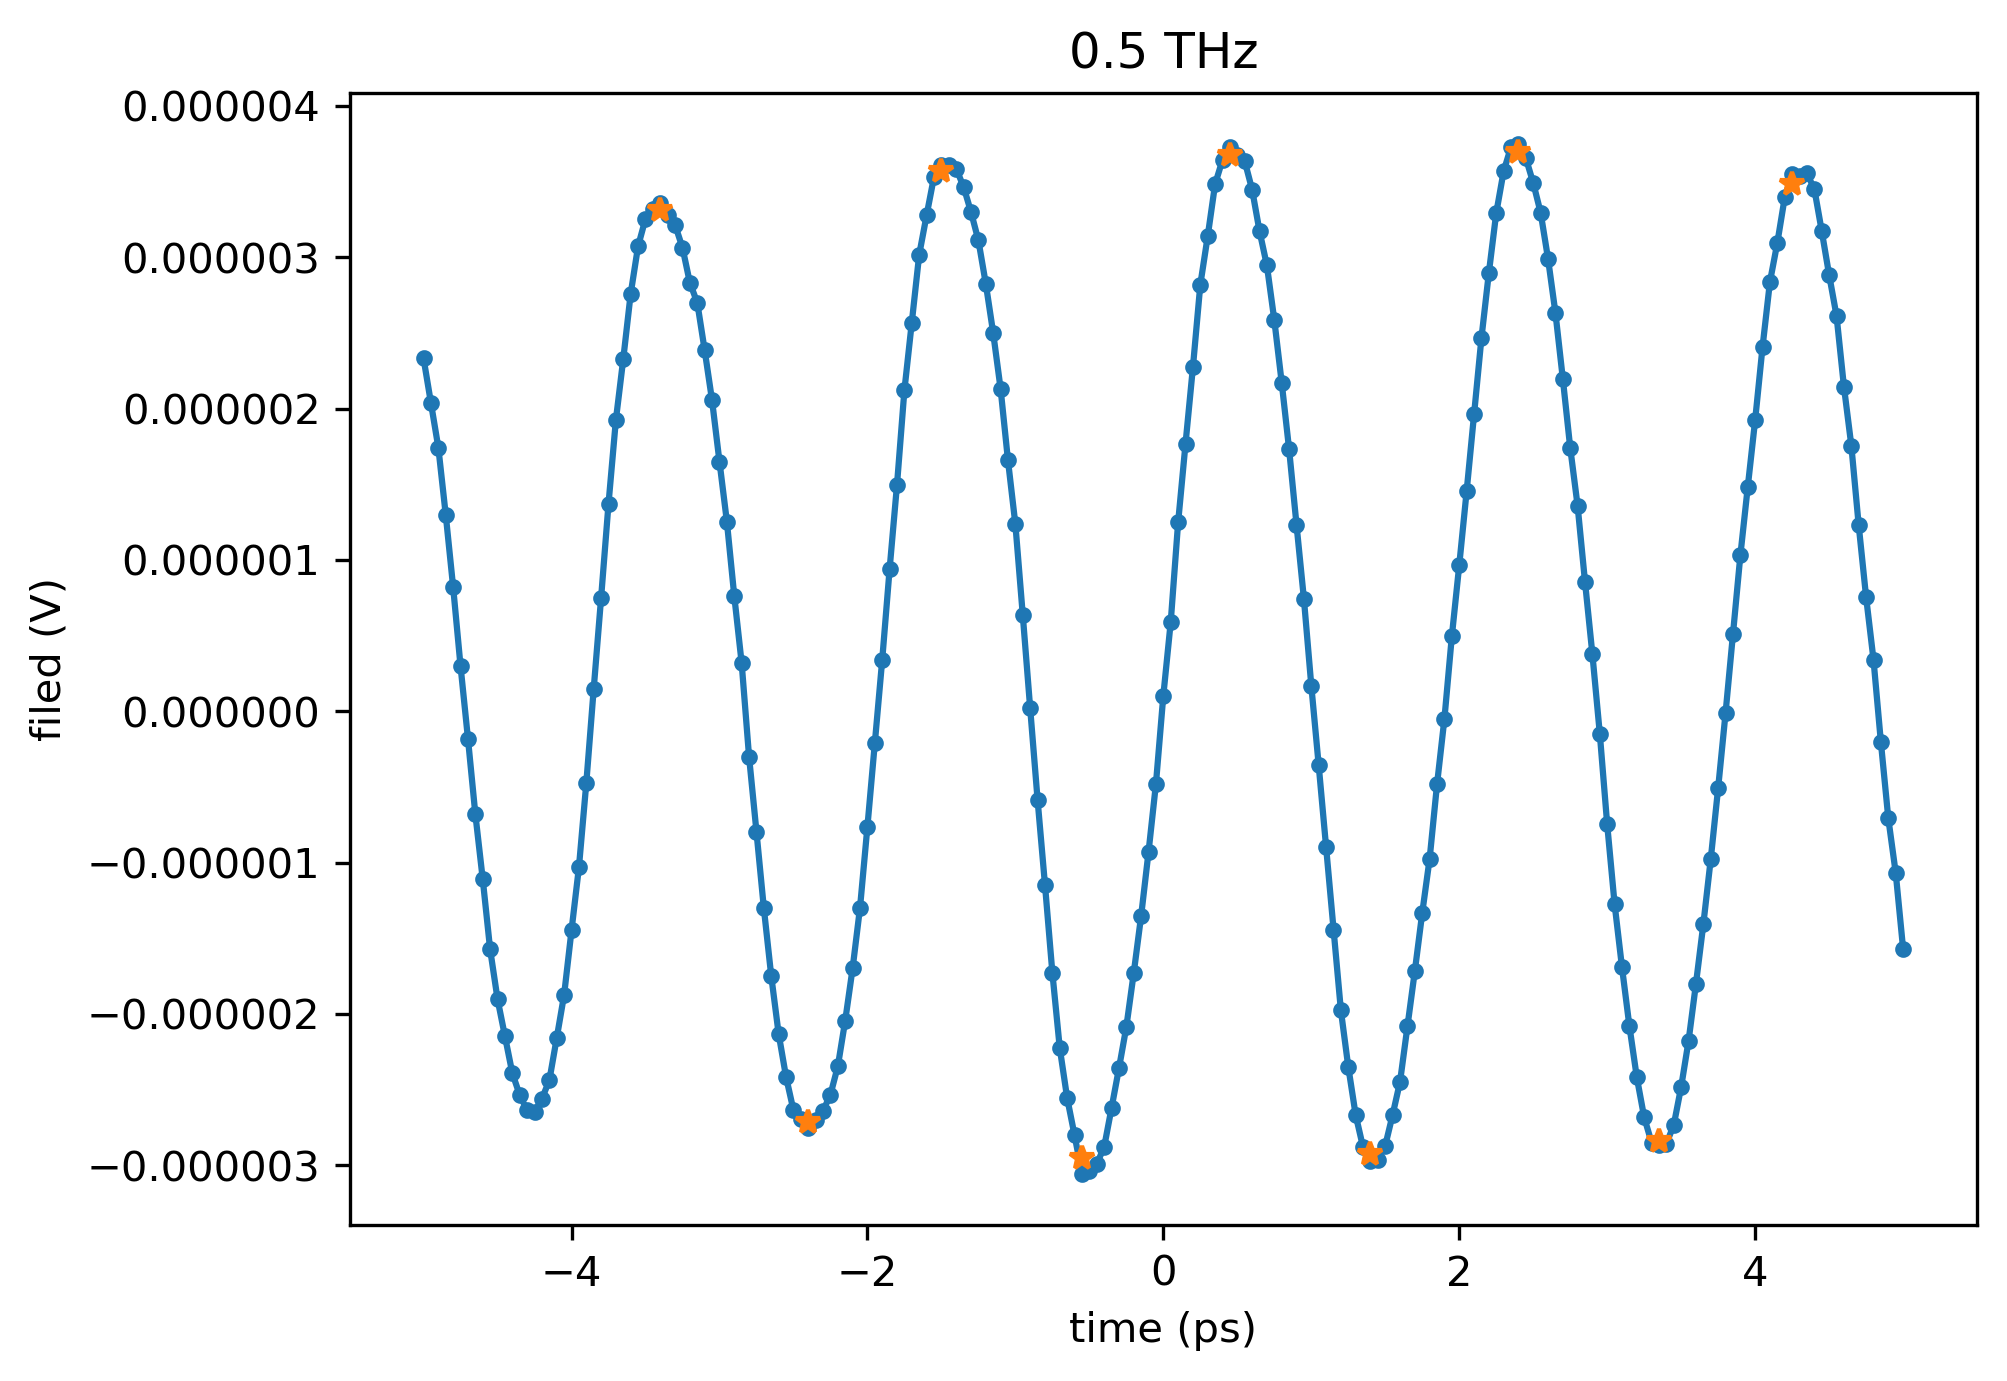

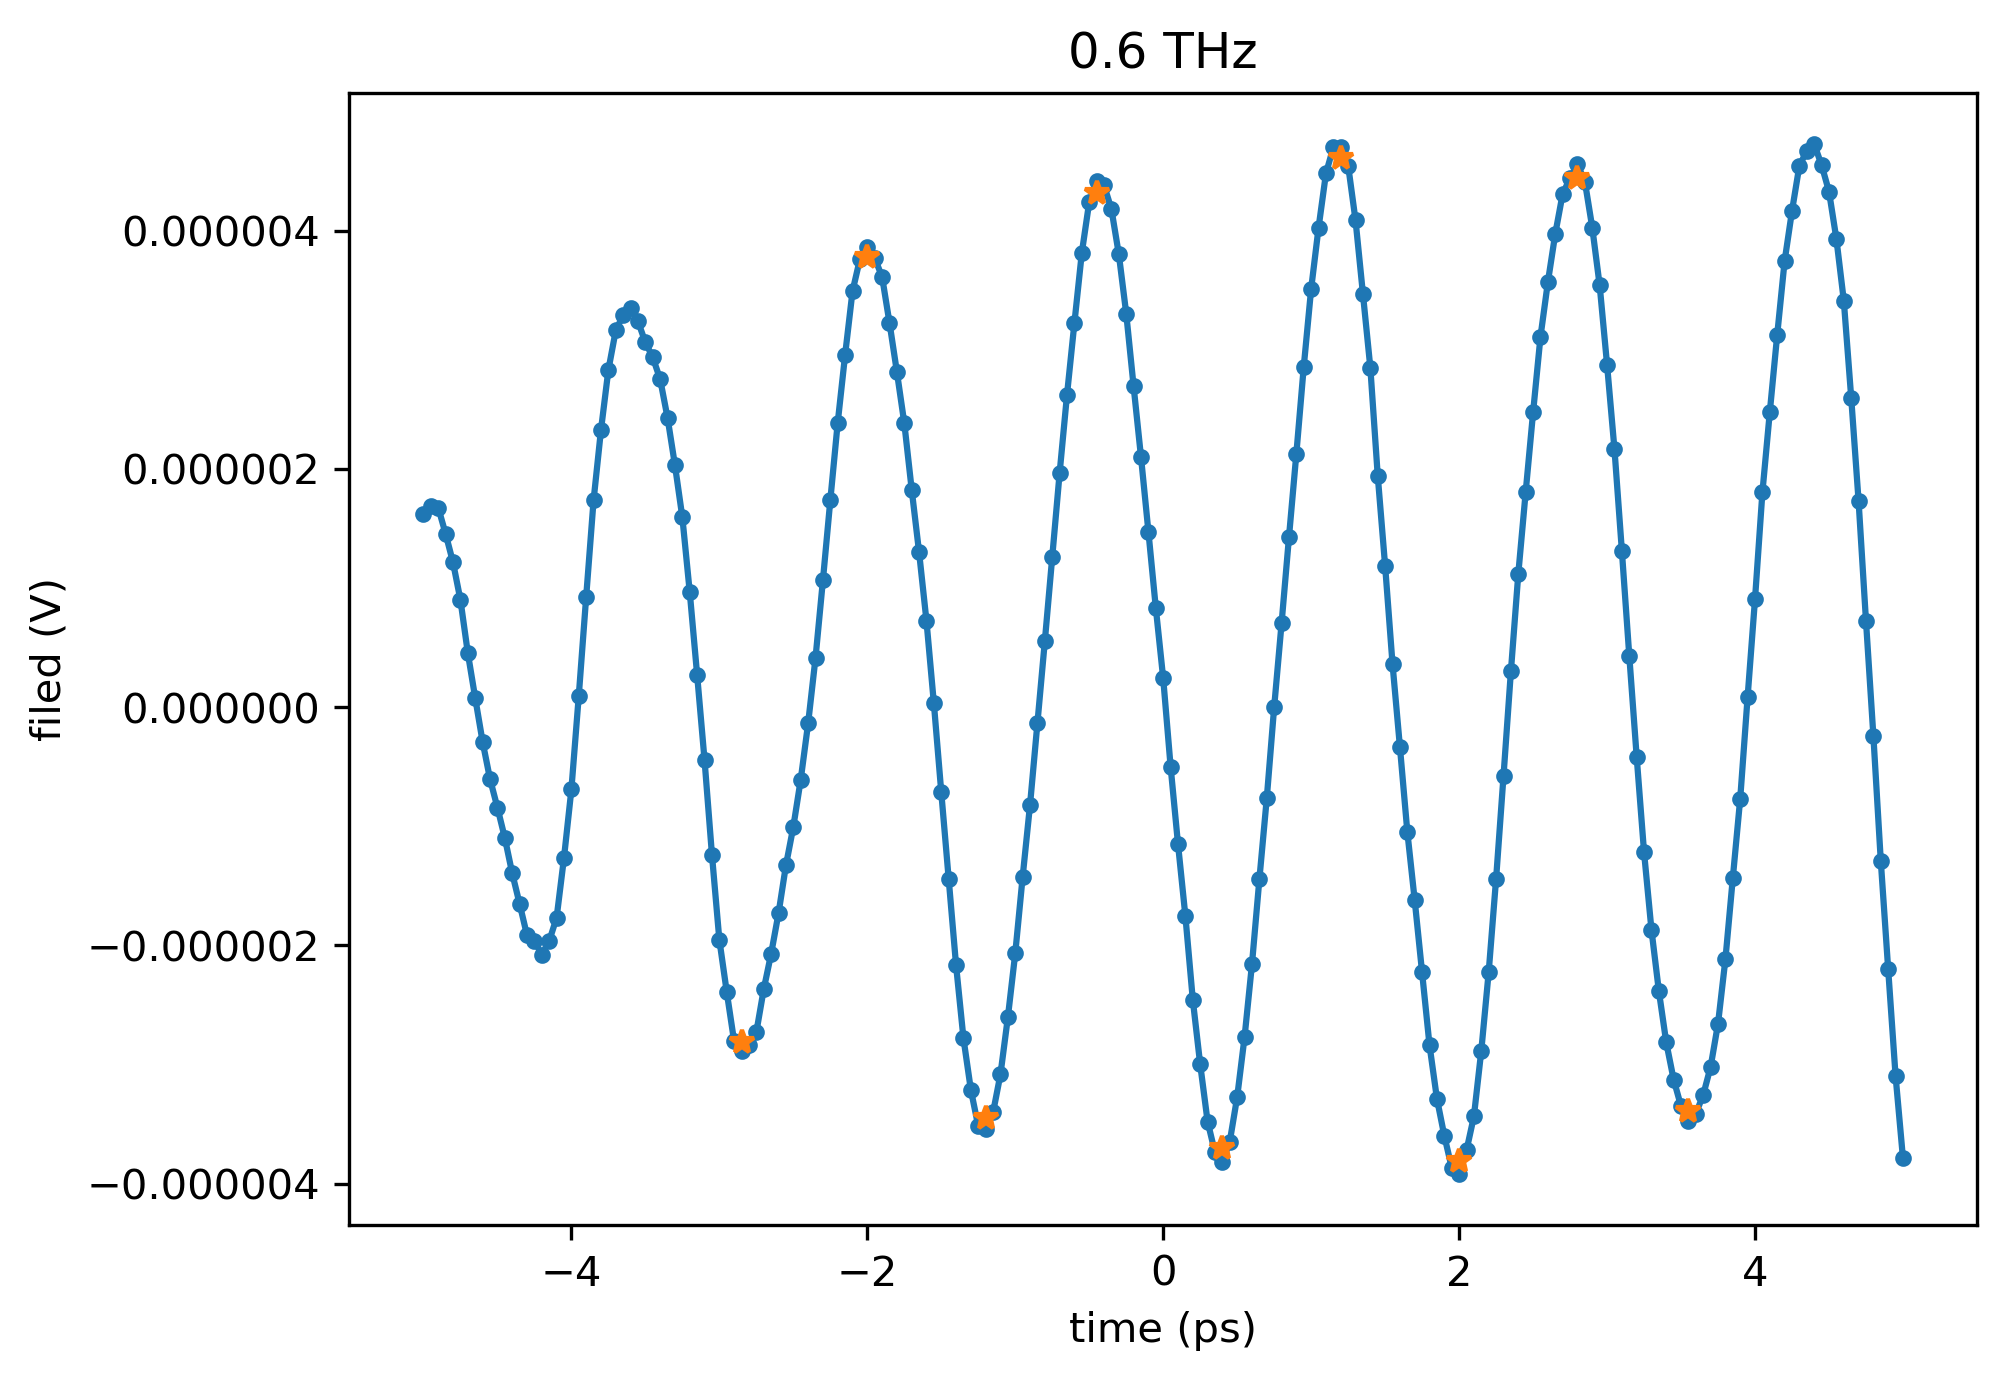

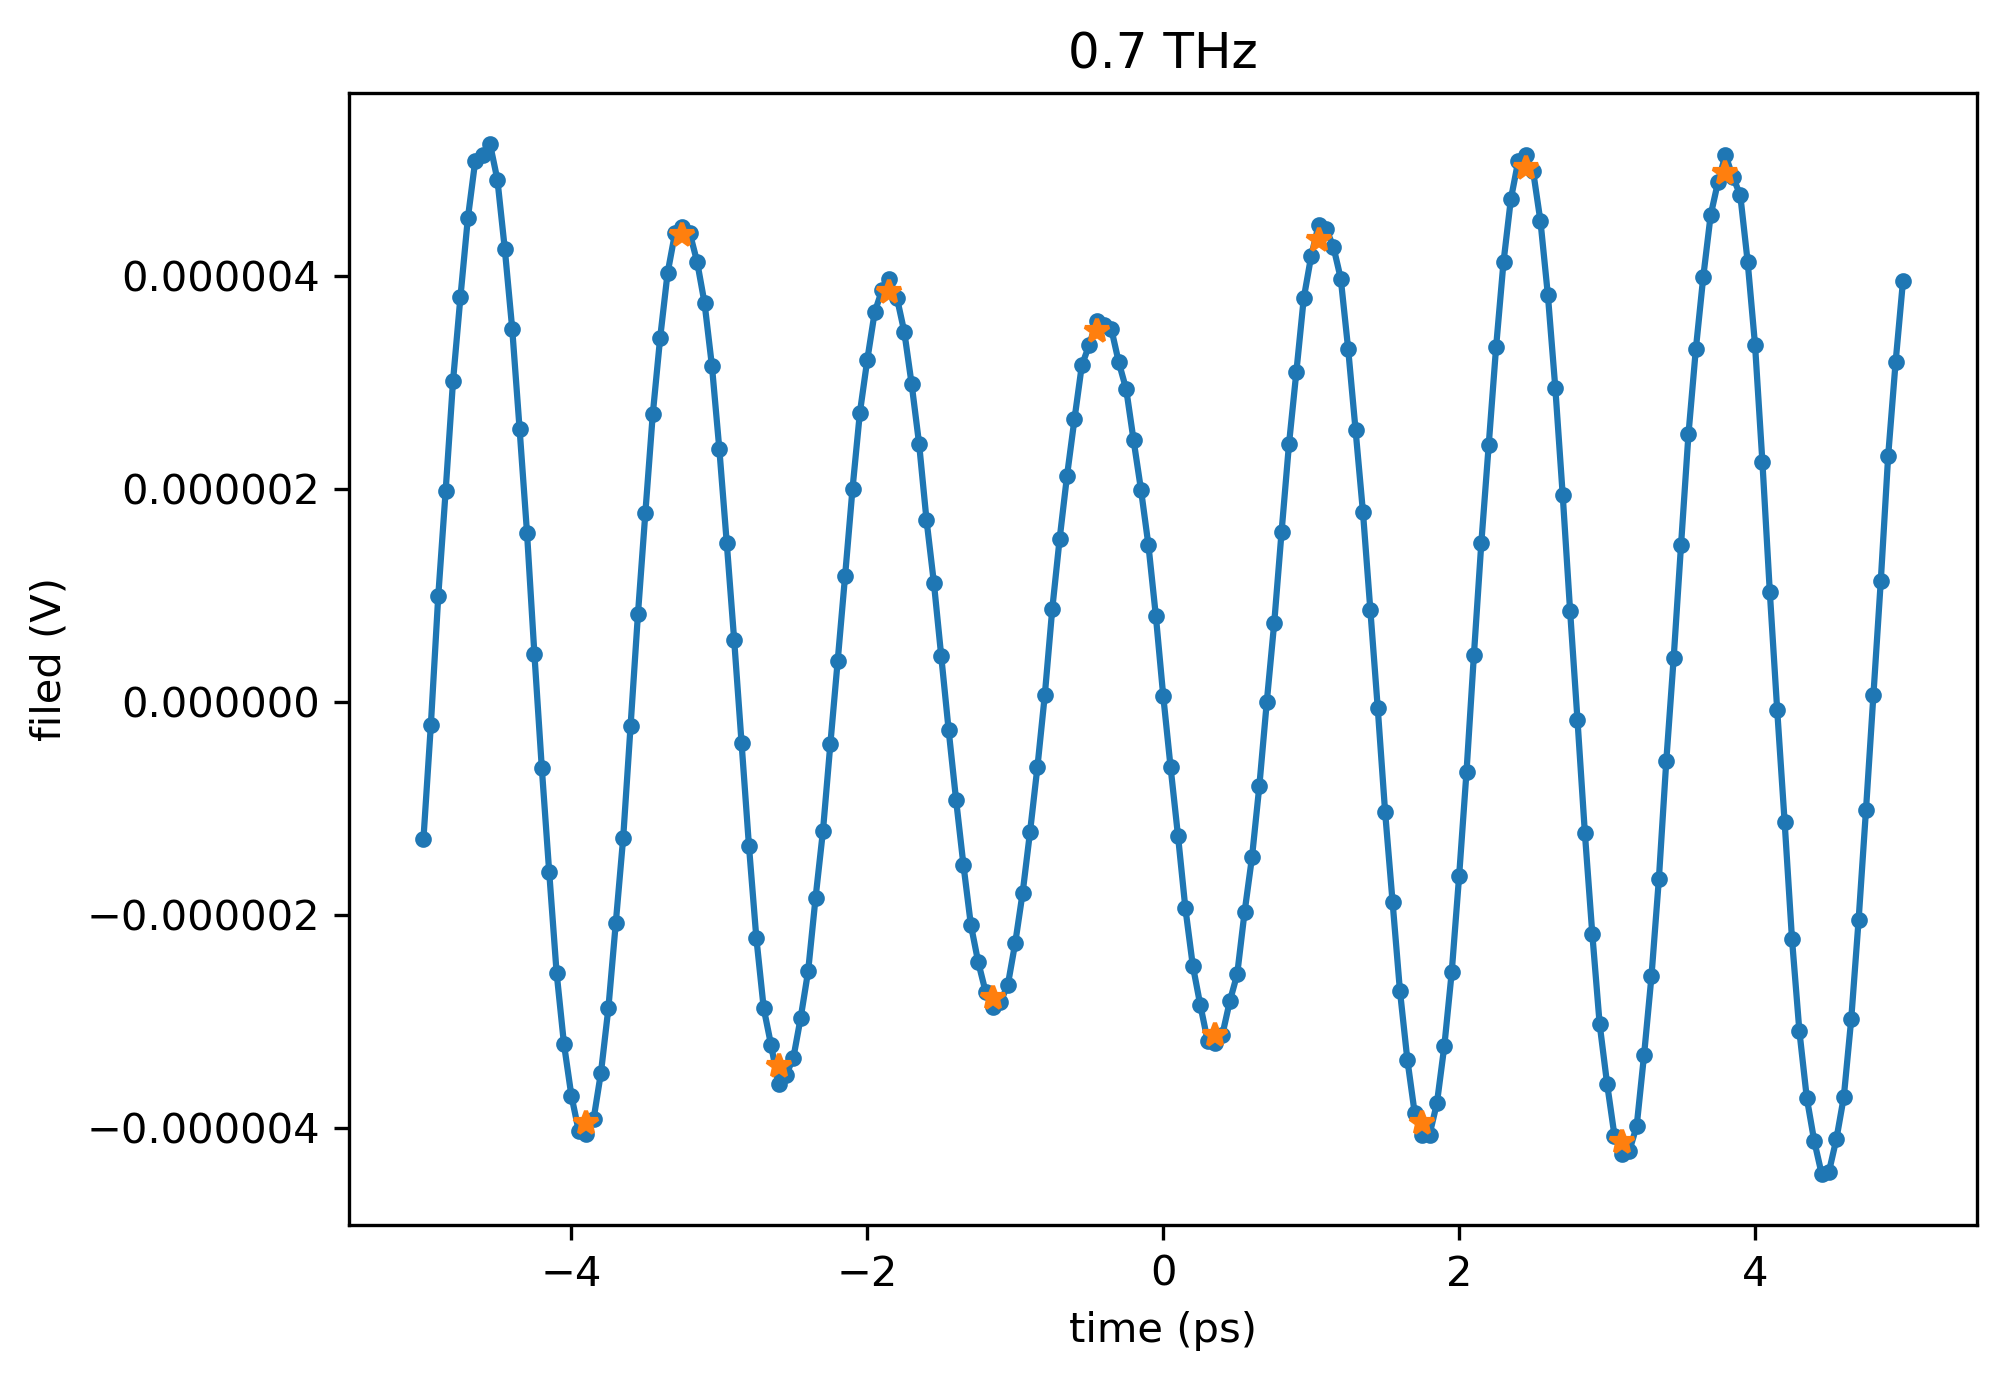

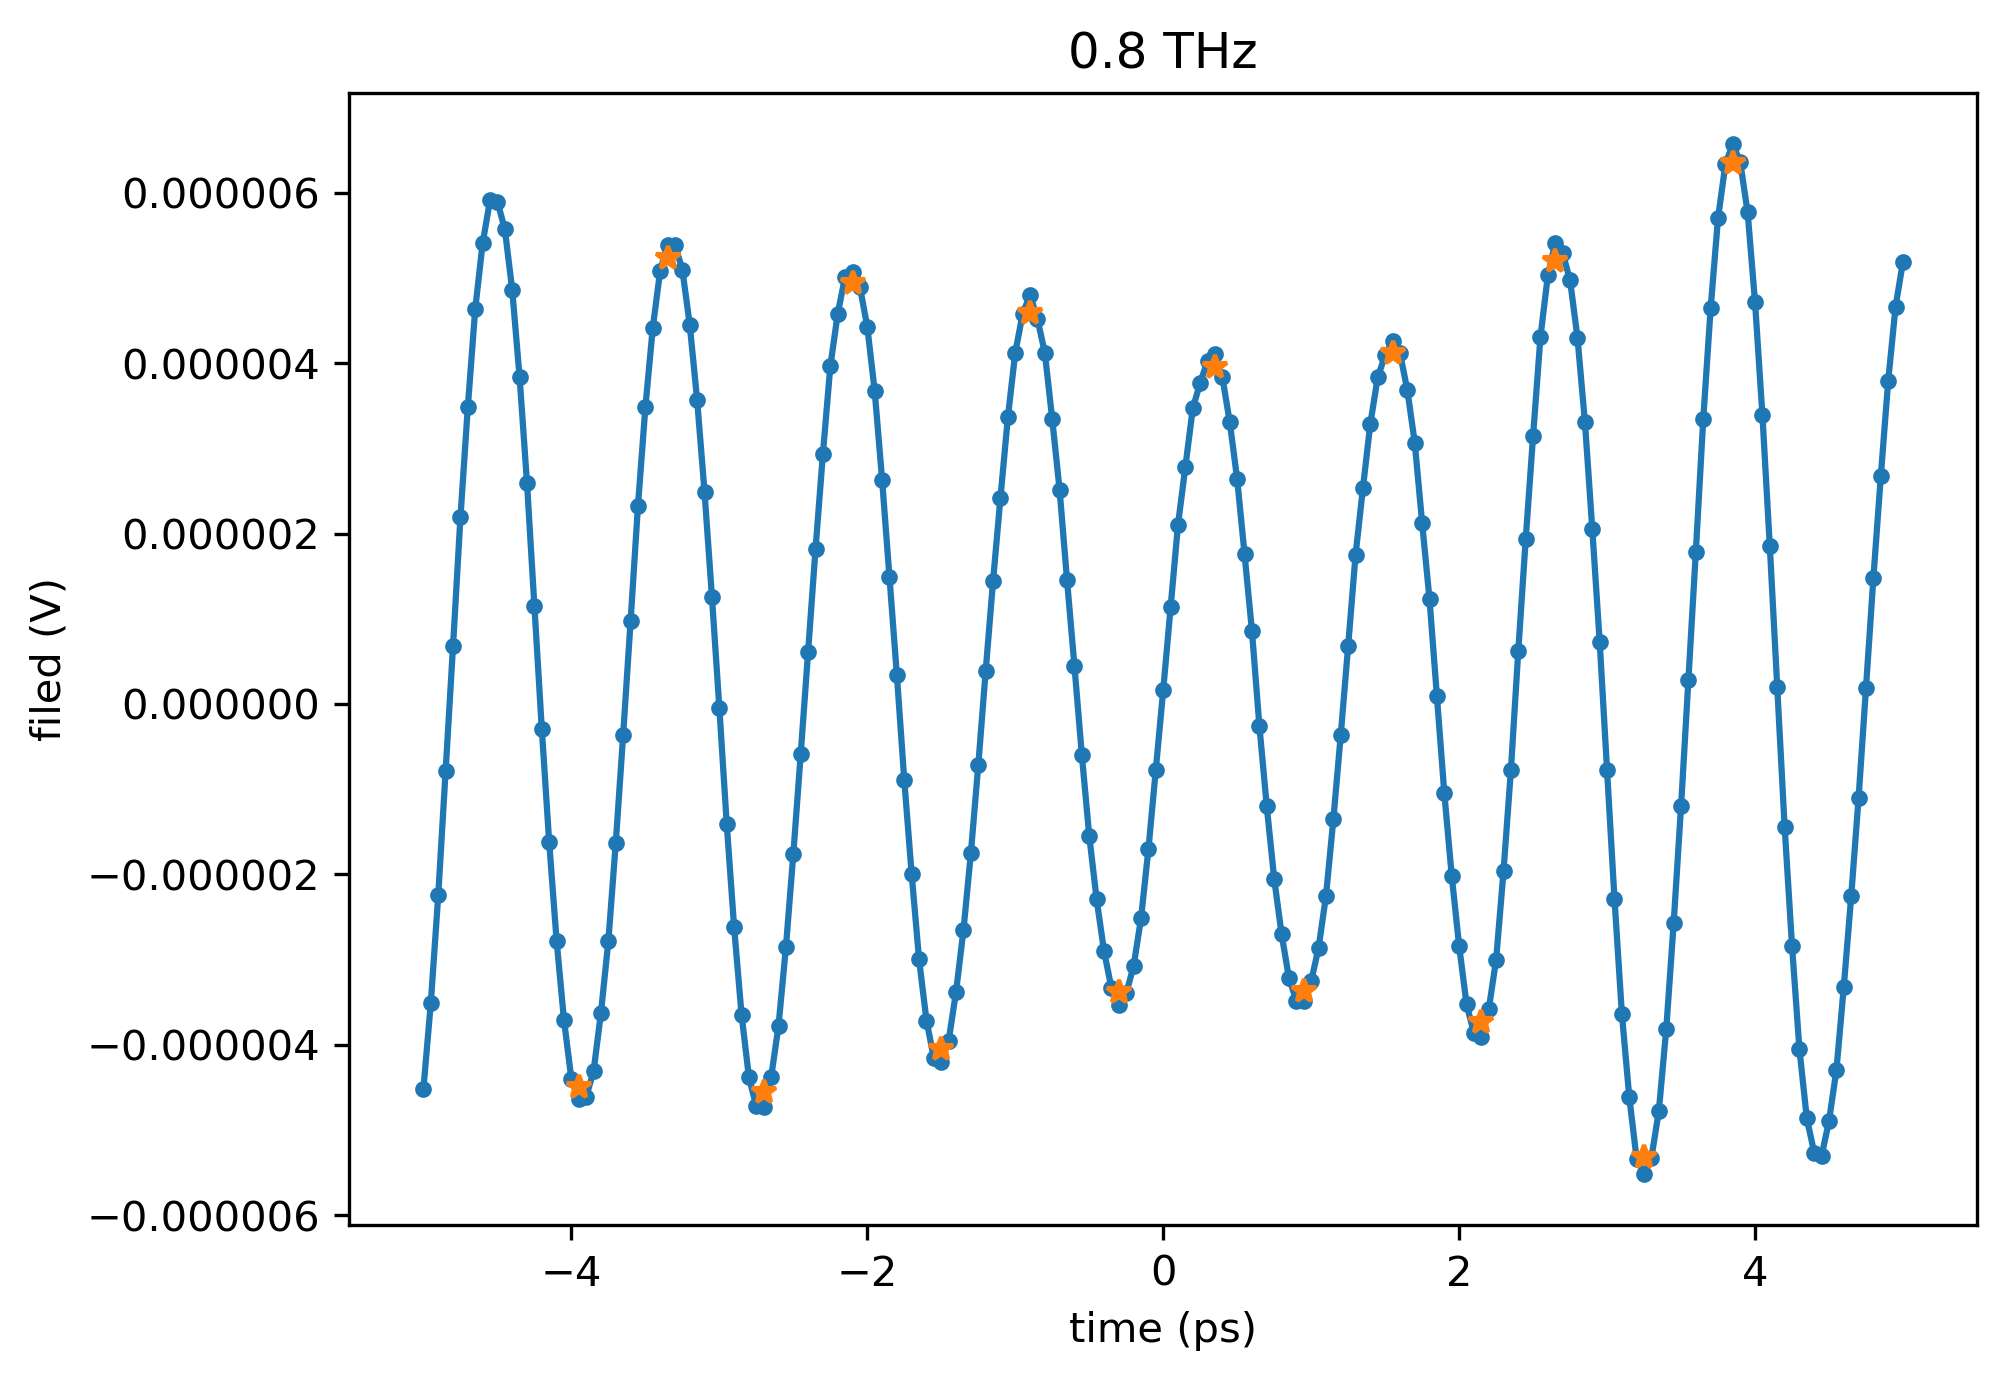

In [36]:
# Plot pulses
for freq, data in pulses.items():
    
    plt.figure(figsize=(7, 5), dpi=300)
    plt.title(freq)
    
    plt.plot(data.time, data.field, '.-')
    
    #t = np.linspace(time.min(), time.max(), 200)
    #plt.plot(t, data.interp_field(t))
    
    plt.plot(data.peaks_time, data.interp_field(data.peaks_time), '*')
    plt.xlabel('time (ps)')
    plt.ylabel('filed (V)')
    plt.show()  
    

## Load experimental superoscilations

In [7]:
def load_experimental_so(file_template):
    loaded_so = []

    for n in range(3):
        data = np.loadtxt(folder_data + file_template.format(n))
        time, field = data.T

        # check that time is time
        assert np.all(np.diff(time) > 0), "`time` is probably not time"

        loaded_so.append(
            Pulse(
                time, 
                field, 
                UnivariateSpline(time, field, ext='zeros', s=0),
                None,
                None
            )
        )
        
    return loaded_so

long_experimental_so = load_experimental_so('/export_SO_short_N{}_night_x.txt')
short_experimental_so = load_experimental_so('/export_SO_long_N{}_night_x.txt')

assert len(long_experimental_so) == len(short_experimental_so)

In [8]:
long_experimental_so, short_experimental_so = short_experimental_so, long_experimental_so

### Plotting short and long measurement at the same time  

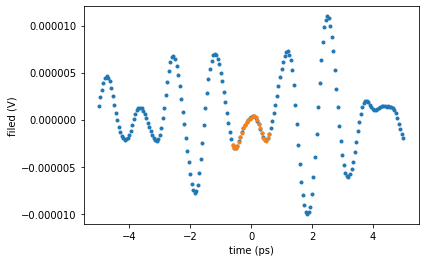

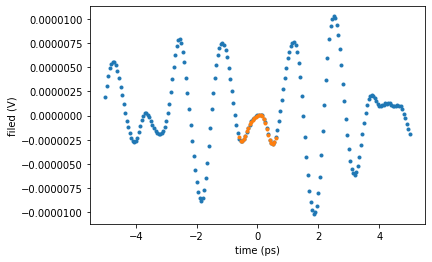

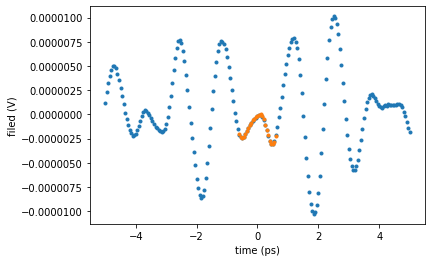

In [9]:
for long, short in zip(long_experimental_so, short_experimental_so):
    plt.plot(long.time, long.field, '.')
    plt.plot(short.time, short.field, '.')
    plt.xlabel('time (ps)')
    plt.ylabel('filed (V)')
    plt.show()

### Manually extract observational time window 

0.6000000000000001


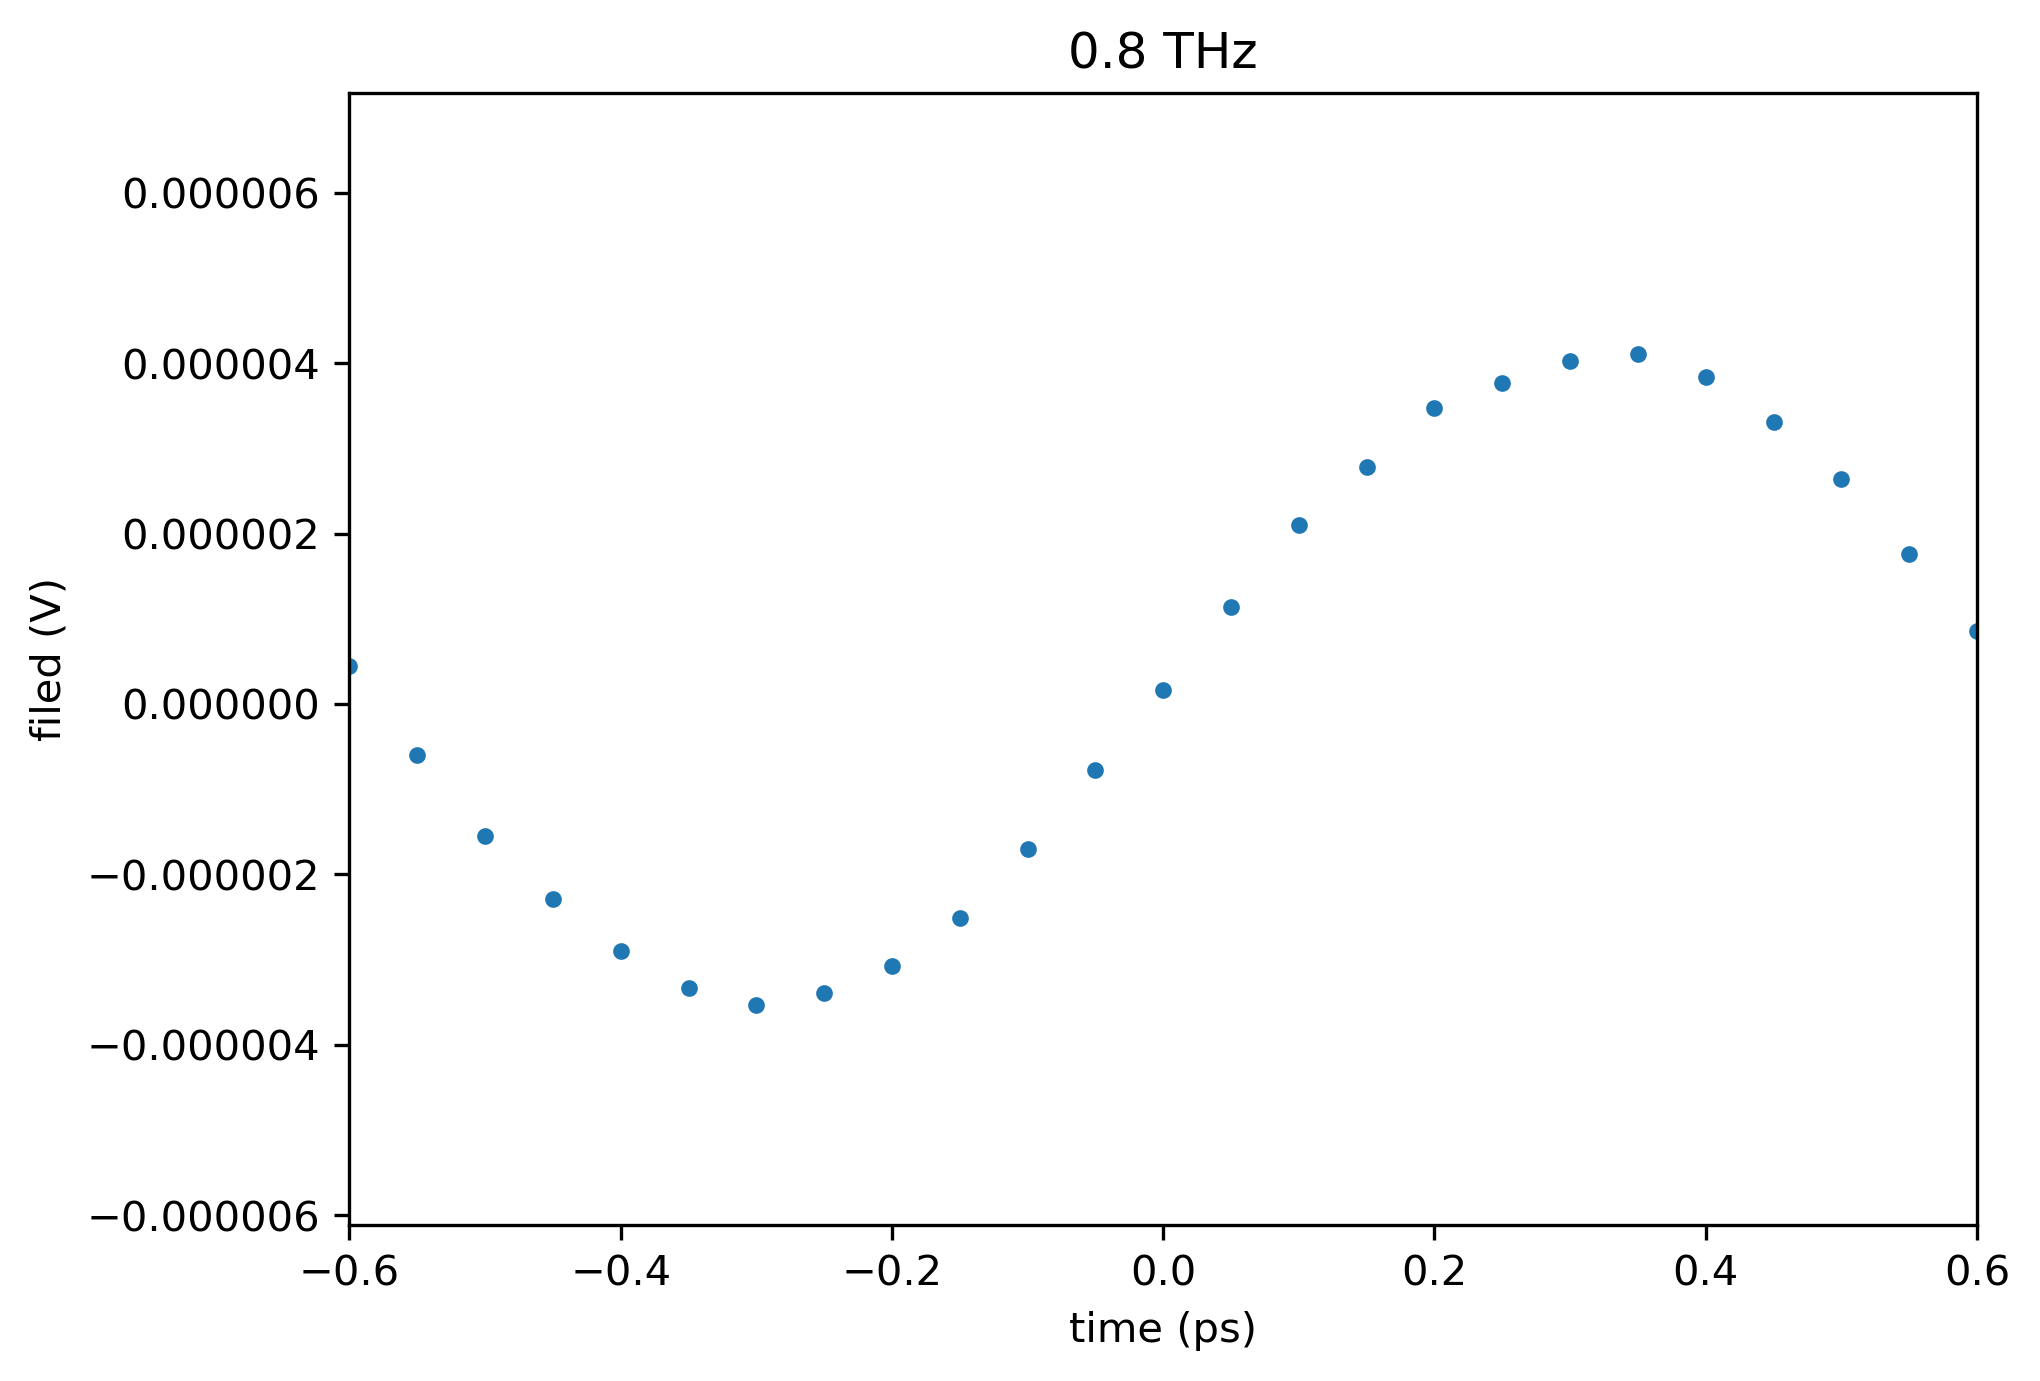

In [10]:
plt.figure(figsize=(7, 5), dpi=300)
    
time = pulses[largest_freq].time
field = pulses[largest_freq].field
half_period = pulses[largest_freq].half_period

print(half_period)

plt.plot(time, field, '.')

#indx = maxima_position[largest_freq]
indx = 200

observational_window = -half_period, half_period
#observational_window = time[indx - 14], time[indx + 12]

plt.xlim(observational_window)
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.title(largest_freq)    
plt.show()

### Plot all pulses within the observational window

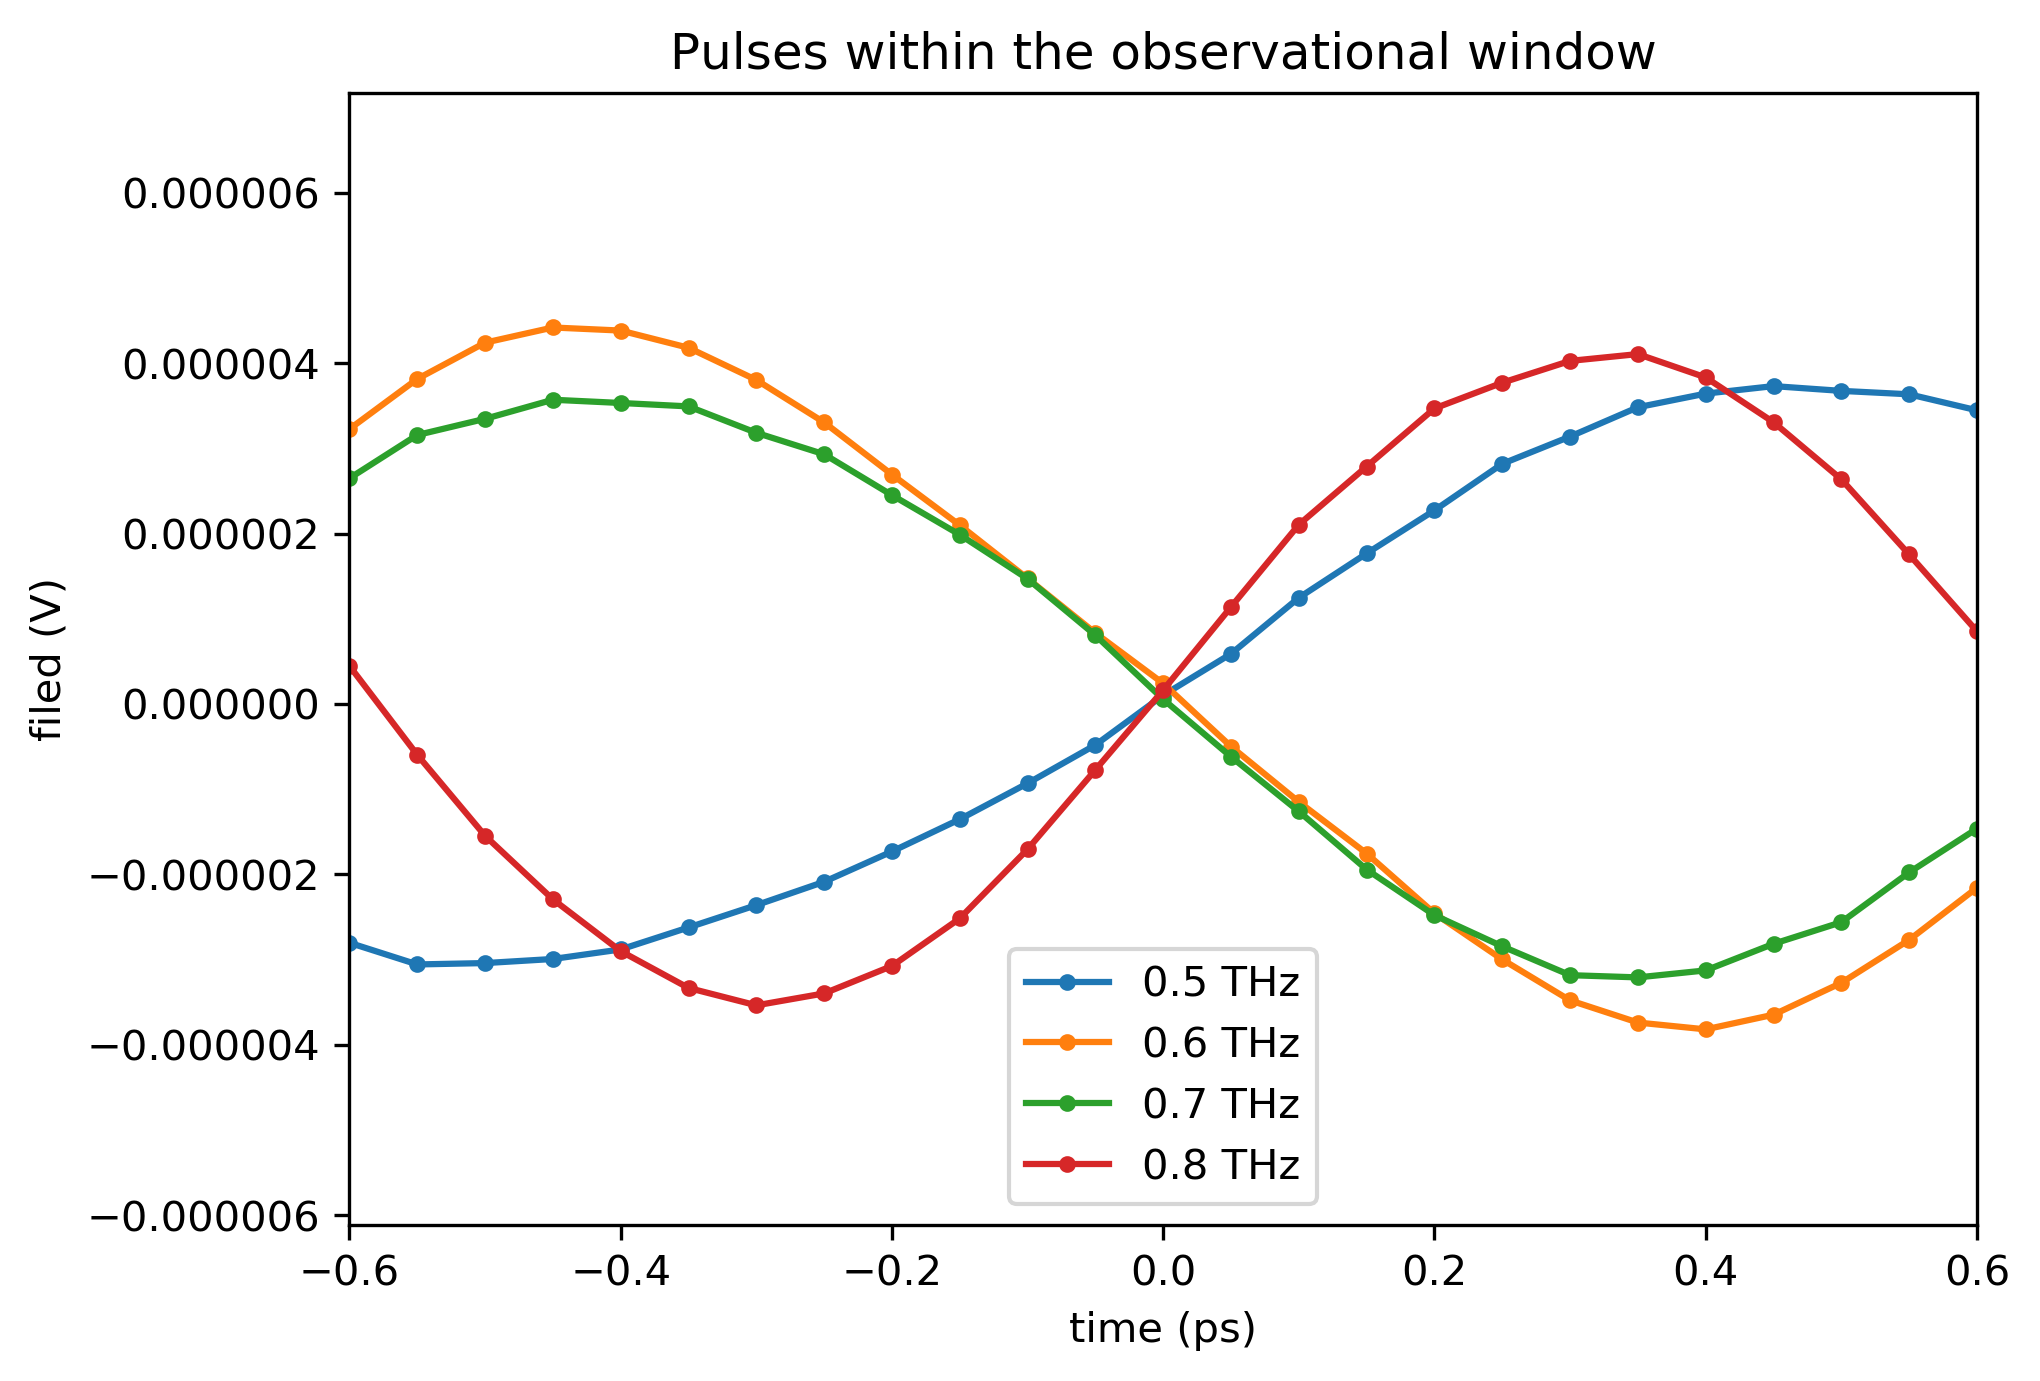

In [11]:
# Plot pulses
plt.figure(figsize=(7, 5), dpi=300)

plt.title("Pulses within the observational window")

for freq, data in pulses.items():
    plt.plot(data.time, data.field, '.-', label=freq)
    

#plt.plot(combined_pulse.time, combined_pulse.field, '.-', color='black', label='experimental pulse')
    
plt.xlim(np.array(observational_window))
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')    

plt.legend()
plt.show()  

# Synthesizing superoscillations 

The first step, Calculate the overlap matrix
$$
 S_{ij}(t_1, t_2) = \int_{t_1}^{t_2} E_i(t) E_j(t) dt
$$

In [12]:
def get_overlap(pulse1, pulse2, int_bounds):
    
    # common time axis
    t = np.union1d(pulse1.time, pulse2.time)
    
    return UnivariateSpline(
        t, 
        pulse1.interp_field(t) * pulse2.interp_field(t), 
        ext='zeros', 
        s=0
    ).integral(*int_bounds)

Get $S_{ij}(-\infty, \infty)$

In [13]:
S_infty = [
    [
        get_overlap(pulse1, pulse2, (-np.inf, np.inf)) 
        for pulse2 in pulses.values()
    ] for pulse1 in pulses.values()
]

S_infty = np.array(S_infty)

assert np.allclose(S_infty, S_infty.T)

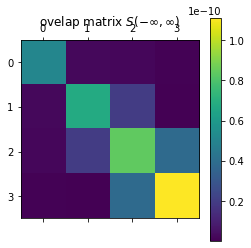

In [14]:
plt.matshow(np.abs(S_infty))
plt.colorbar()
plt.title("ovelap matrix $S(-\infty, \infty)$")
plt.show()

Get overlap matrix for the observational window

In [15]:
S_observ = [
    [
        get_overlap(pulse1, pulse2, observational_window) 
        for pulse2 in pulses.values()
    ] for pulse1 in pulses.values()
]

S_observ = np.array(S_observ)

assert np.allclose(S_observ, S_observ.T)

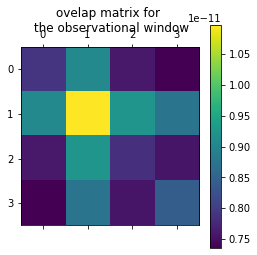

In [16]:
plt.matshow(np.abs(S_observ))
plt.colorbar()
plt.title("ovelap matrix for \n the observational window")
plt.show()

### Finding optimal strategies for generating supperoscilations via eigenvectors

In [17]:
vals, vecs = eigh(S_observ) #, S_infty)

# Ploting superoscilations

# Use refined time axis for the largest frequency component
fastest = pulses[largest_freq]
t = fastest.time
t = np.linspace(t.min(), t.max(), 5 * t.size)

# extract indices of the observational window
ow1 = np.searchsorted(t, observational_window[0], side='left')
ow2 = np.searchsorted(t, observational_window[1], side='right')

# extract indices of the larger window
Lw1 = np.searchsorted(t, 10 * observational_window[0], side='left')
Lw2 = np.searchsorted(t, 10 * observational_window[1], side='right')

for num, eig_vector in enumerate(vecs.T):
    
    # a sanity check
    #assert np.allclose(eig_vector.T @ S_infty @ eig_vector, 1.)
    
    # Normalizing amplitudes
    #eig_vector = eig_vector / np.abs(eig_vector).max()
    
    # get superoscilating field
    field = sum(
        c * _.interp_field(t) for c, _ in zip(eig_vector, pulses.values())
    )
    
    # plot zoom in view
    fig, (ax1, ax1_, ax1__) = plt.subplots(1, 3, figsize=(10, 3), dpi=300)
    
    t_ow = t[ow1:ow2]
    
    color1 = 'tab:red'
    ax1.set_ylabel('combined field (V)', color=color1)
    ax1.plot(t_ow, field[ow1:ow2], color=color1)
    #ax1.plot(t_ow, combined_pulse.interp_field(t_ow) / 10, color='black')
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.set_xlabel('time (ps)')
    
    ax2 = ax1.twinx() 
    
    color2 = 'tab:blue'
    ax2.set_ylabel('highest frequecy component (v)', color=color2)
    ax2.plot(t_ow, fastest.interp_field(t_ow), '--', color=color2)
    #ax2.plot(fastest.time, fastest.field, '*')
    #ax2.set_xlim(observational_window)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    
    # plot zoom out view
    
    ax1 = ax1_
    
    t_lw = t[Lw1:Lw2]
    
    ax1.set_ylabel('combined field (V)', color=color1)
    ax1.plot(t_lw, field[Lw1:Lw2], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.plot(t_lw, combined_pulse.interp_field(t_lw), color='black')
    
    ax1.set_xlabel('time (ps)')
    
    ax2 = ax1.twinx() 
    
    ax2.set_ylabel('highest frequecy component (V)', color=color2)
    ax2.plot(t_lw, fastest.interp_field(t_lw), '--', color=color2)
    #ax2.plot(fastest.time, fastest.field, '*')
    #ax2.set_xlim(10 * np.array(observational_window))
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # plot pulses
    ax1 = ax1__
    
    ax1.bar(np.arange(eig_vector.size), eig_vector, color='tab:green')
    ax1.set_xticks(np.arange(eig_vector.size))
    ax1.set_xticklabels(pulses, rotation='vertical')
    #ax1.set_xlabel('THz')
    ax1.set_ylabel('$a_j$')
    
    fig.tight_layout()
    
    plt.savefig('fig_{}.png'.format(num), transparent=True)
    
    plt.show()

# New combinatorial method

Define all time possible time delays  

In [18]:
all_time_delays = list(product(*[_.peaks_time for _ in pulses.values()]))
len(all_time_delays)

13608

Time window for constructing superoscilations

In [19]:
half_period = pulses[largest_freq].half_period
time_window = np.linspace(-half_period, half_period, 100)

if same_time_axis:
    time_window_raw = time[(time >= -half_period) & (time <= half_period)] 

## Get superoscilationsby using time delays only 

In [20]:
def get_combined_field(time_delays, time_window):
    return sum(
        _.interp_field(time_window - delay) for delay, _ in zip(time_delays, pulses.values())
    )

def inegral_without_ampl_modulation(time_delays):
    
    return simps(get_combined_field(time_delays, time_window) ** 2, time_window)

In [21]:
with Pool() as pool:
    intensity_without_ampl_modulation = pool.map(inegral_without_ampl_modulation, tqdm(all_time_delays))

 453852774/453852774 [34:55<00:00, 216554.52it/s]

Extract the best candidates for getting superoscilations  

In [22]:
intensity_without_ampl_modulation = np.array(intensity_without_ampl_modulation)
indx = np.argsort(intensity_without_ampl_modulation)
intensity_without_ampl_modulation = intensity_without_ampl_modulation[indx]

all_time_delays = np.array(all_time_delays)[indx]

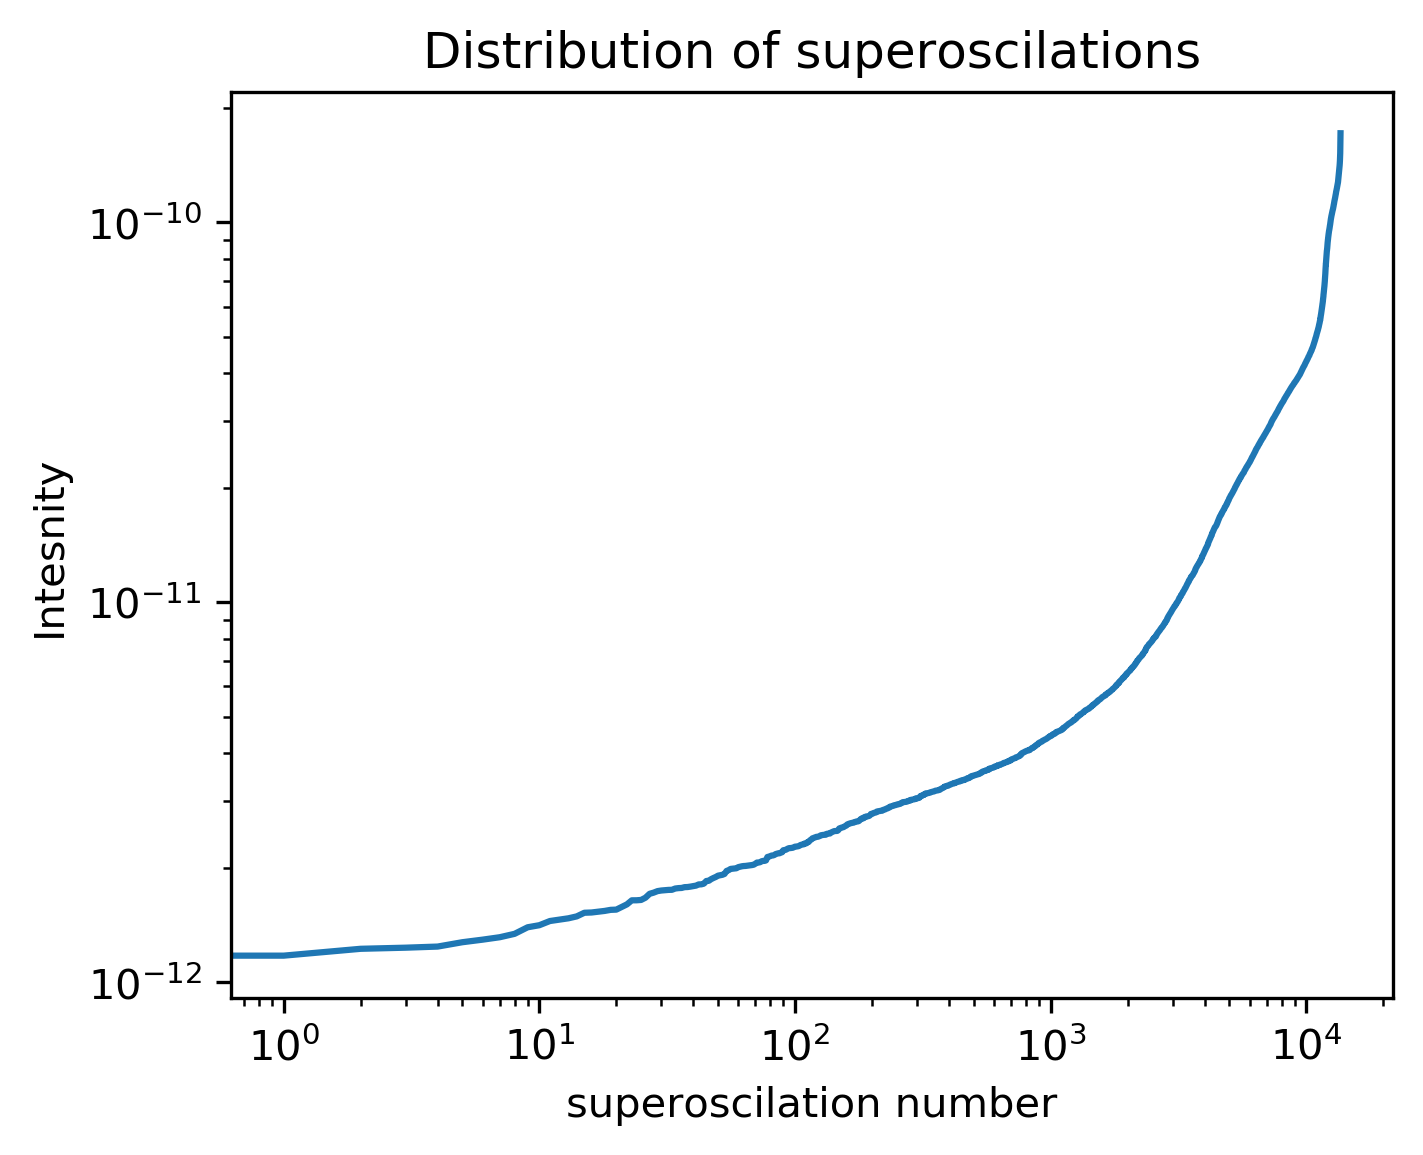

In [23]:
plt.figure(figsize=(5,4), dpi=300)
plt.title("Distribution of superoscilations")
plt.loglog(intensity_without_ampl_modulation)
plt.xlabel('superoscilation number')
plt.ylabel('Intesnity')
plt.show()

## Get superoscilations that best matches the experimental result

def get_distance_to_experimental(time_delays):
    
    return simps(
        (get_combined_field(time_delays, time_window) - combined_pulse.interp_field(time_window))** 2, 
        time_window
    )

with Pool() as pool:
    distance_to_experimental = pool.map(get_distance_to_experimental, tqdm(all_time_delays))
    
indx = np.argsort(distance_to_experimental)
distance_to_experimental = np.array(distance_to_experimental)[indx]

best_match_time_delays = all_time_delays[indx[0]]

plt.plot(distance_to_experimental)
plt.show()

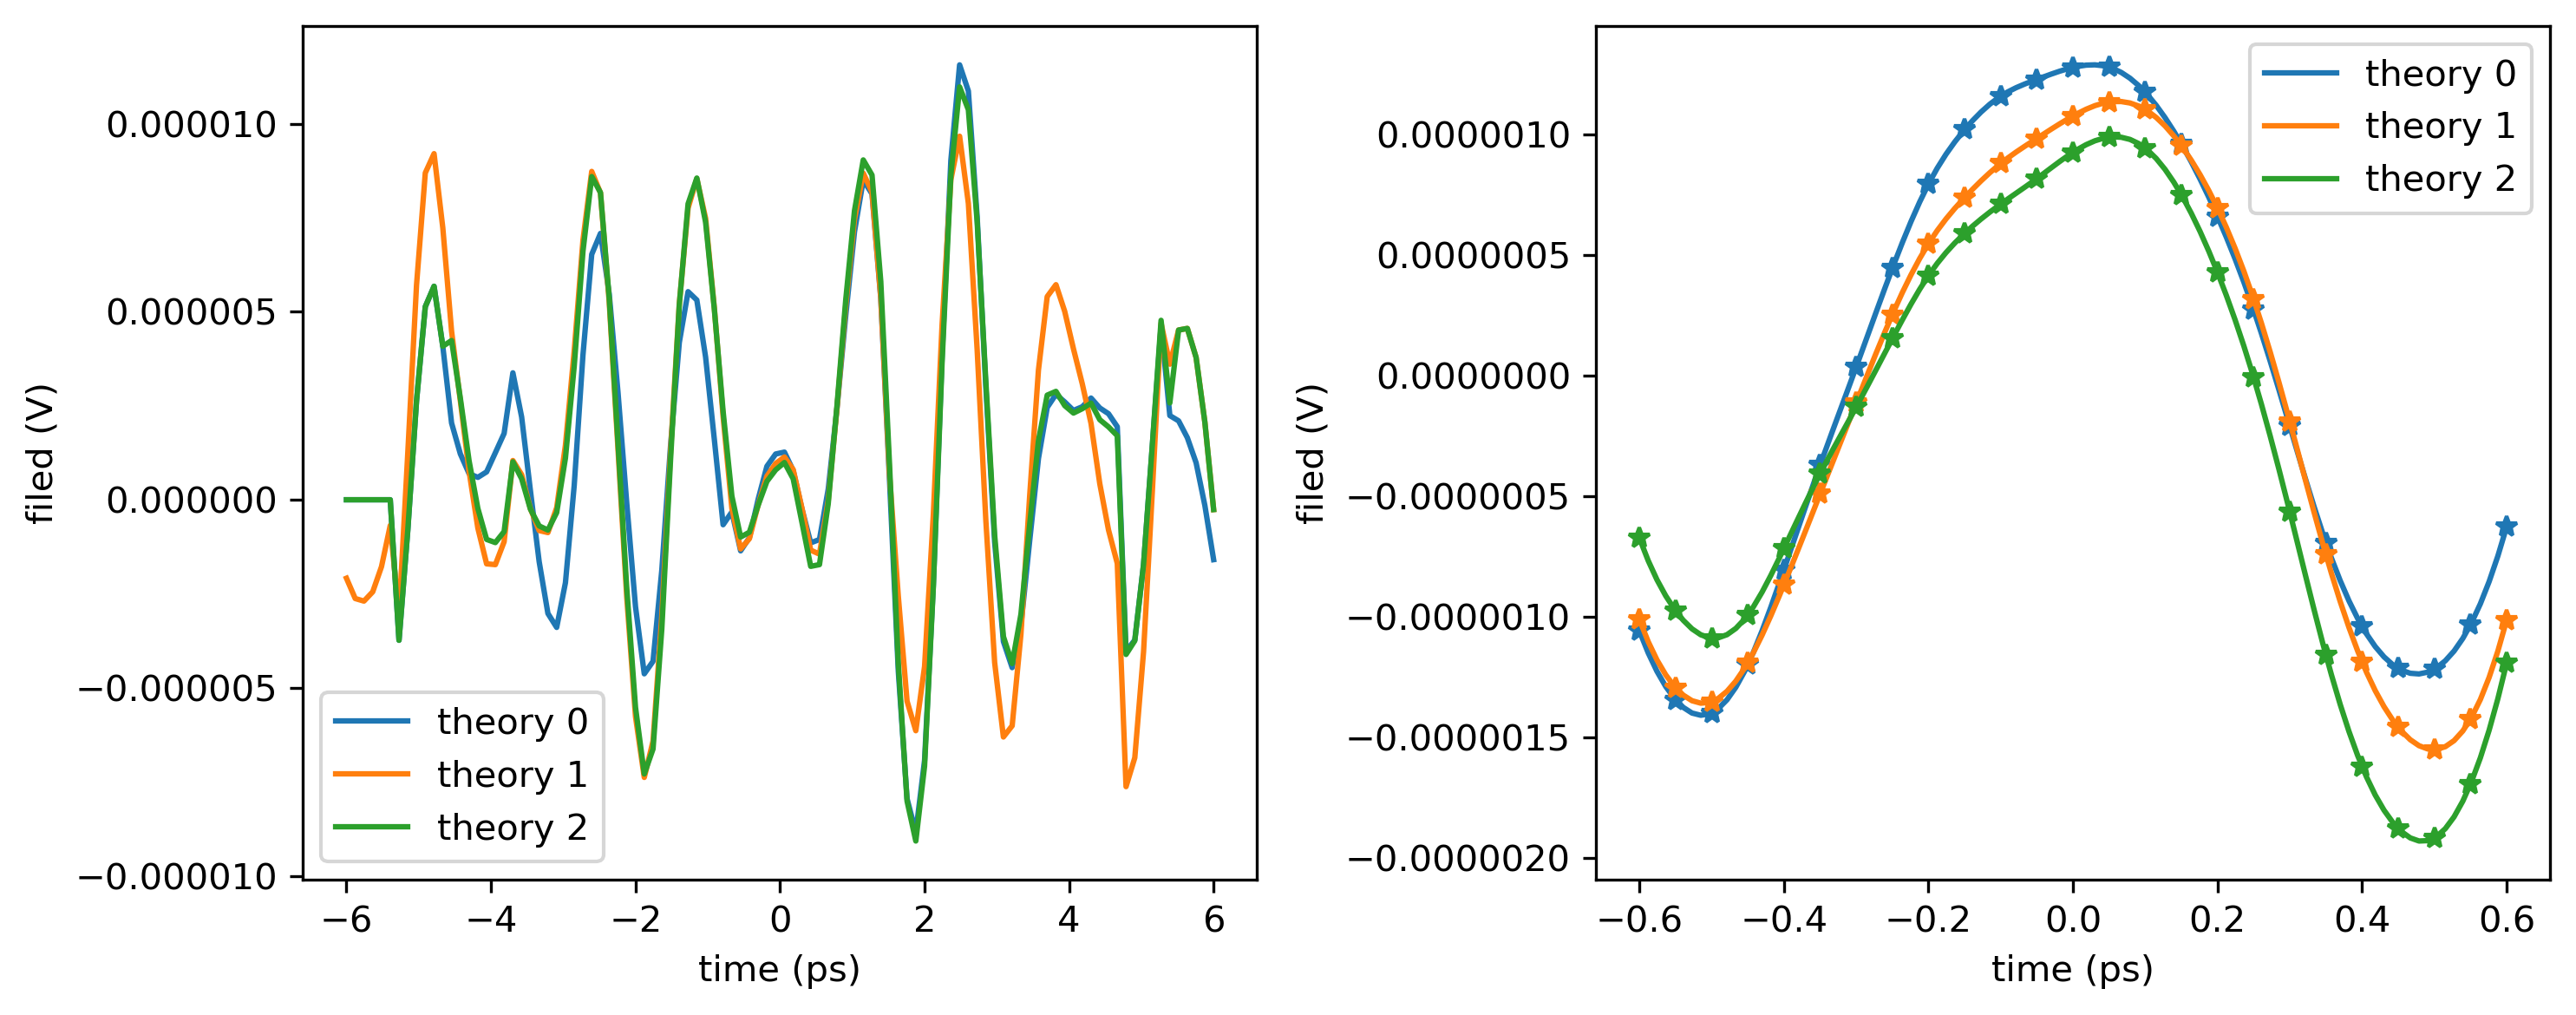

In [24]:
plt.figure(figsize=(10,4), dpi=300)
plt.title("Best superoscilations")

plt.subplot(121)

long_time_window = 10 * time_window

for n, time_delays in enumerate(all_time_delays[:3]):
    plt.plot(long_time_window, get_combined_field(time_delays, long_time_window), label="theory {}".format(n))
    
#for n, long in enumerate(long_experimental_so[:3]):
#    plt.plot(long.time, long.field, '.', label="experiment {}".format(n))
    
    
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.legend()

plt.subplot(122)

for n, time_delays in enumerate(all_time_delays[:3]):
    line = plt.plot(time_window, get_combined_field(time_delays, time_window), label="theory {}".format(n))
    line = line[0]
    
    # display raw points
    plt.plot(time_window_raw, get_combined_field(time_delays, time_window_raw), '*', color = line.get_color())

#for n, short in enumerate(short_experimental_so[:3]):
#    plt.plot(short.time, short.field, '.', label="experiment {}".format(n))
    

plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.legend()

plt.tight_layout()
plt.savefig(get_unique_filename("predicted_so_{}.png"))

plt.show()  

In [25]:
all_time_delays[:10]

array([[ 4.25,  1.2 ,  0.35, -0.3 ],
       [-3.4 ,  1.2 ,  0.35, -0.3 ],
       [ 0.45,  1.2 ,  0.35, -0.3 ],
       [ 0.45, -2.  ,  0.35, -0.3 ],
       [ 4.25, -2.  ,  0.35, -0.3 ],
       [-1.5 ,  1.2 ,  0.35, -0.3 ],
       [-3.4 , -2.  ,  0.35, -0.3 ],
       [ 2.4 , -2.  ,  0.35, -0.3 ],
       [ 0.45,  3.55, -1.85,  3.25],
       [ 2.4 , -2.85, -1.85, -0.3 ]])

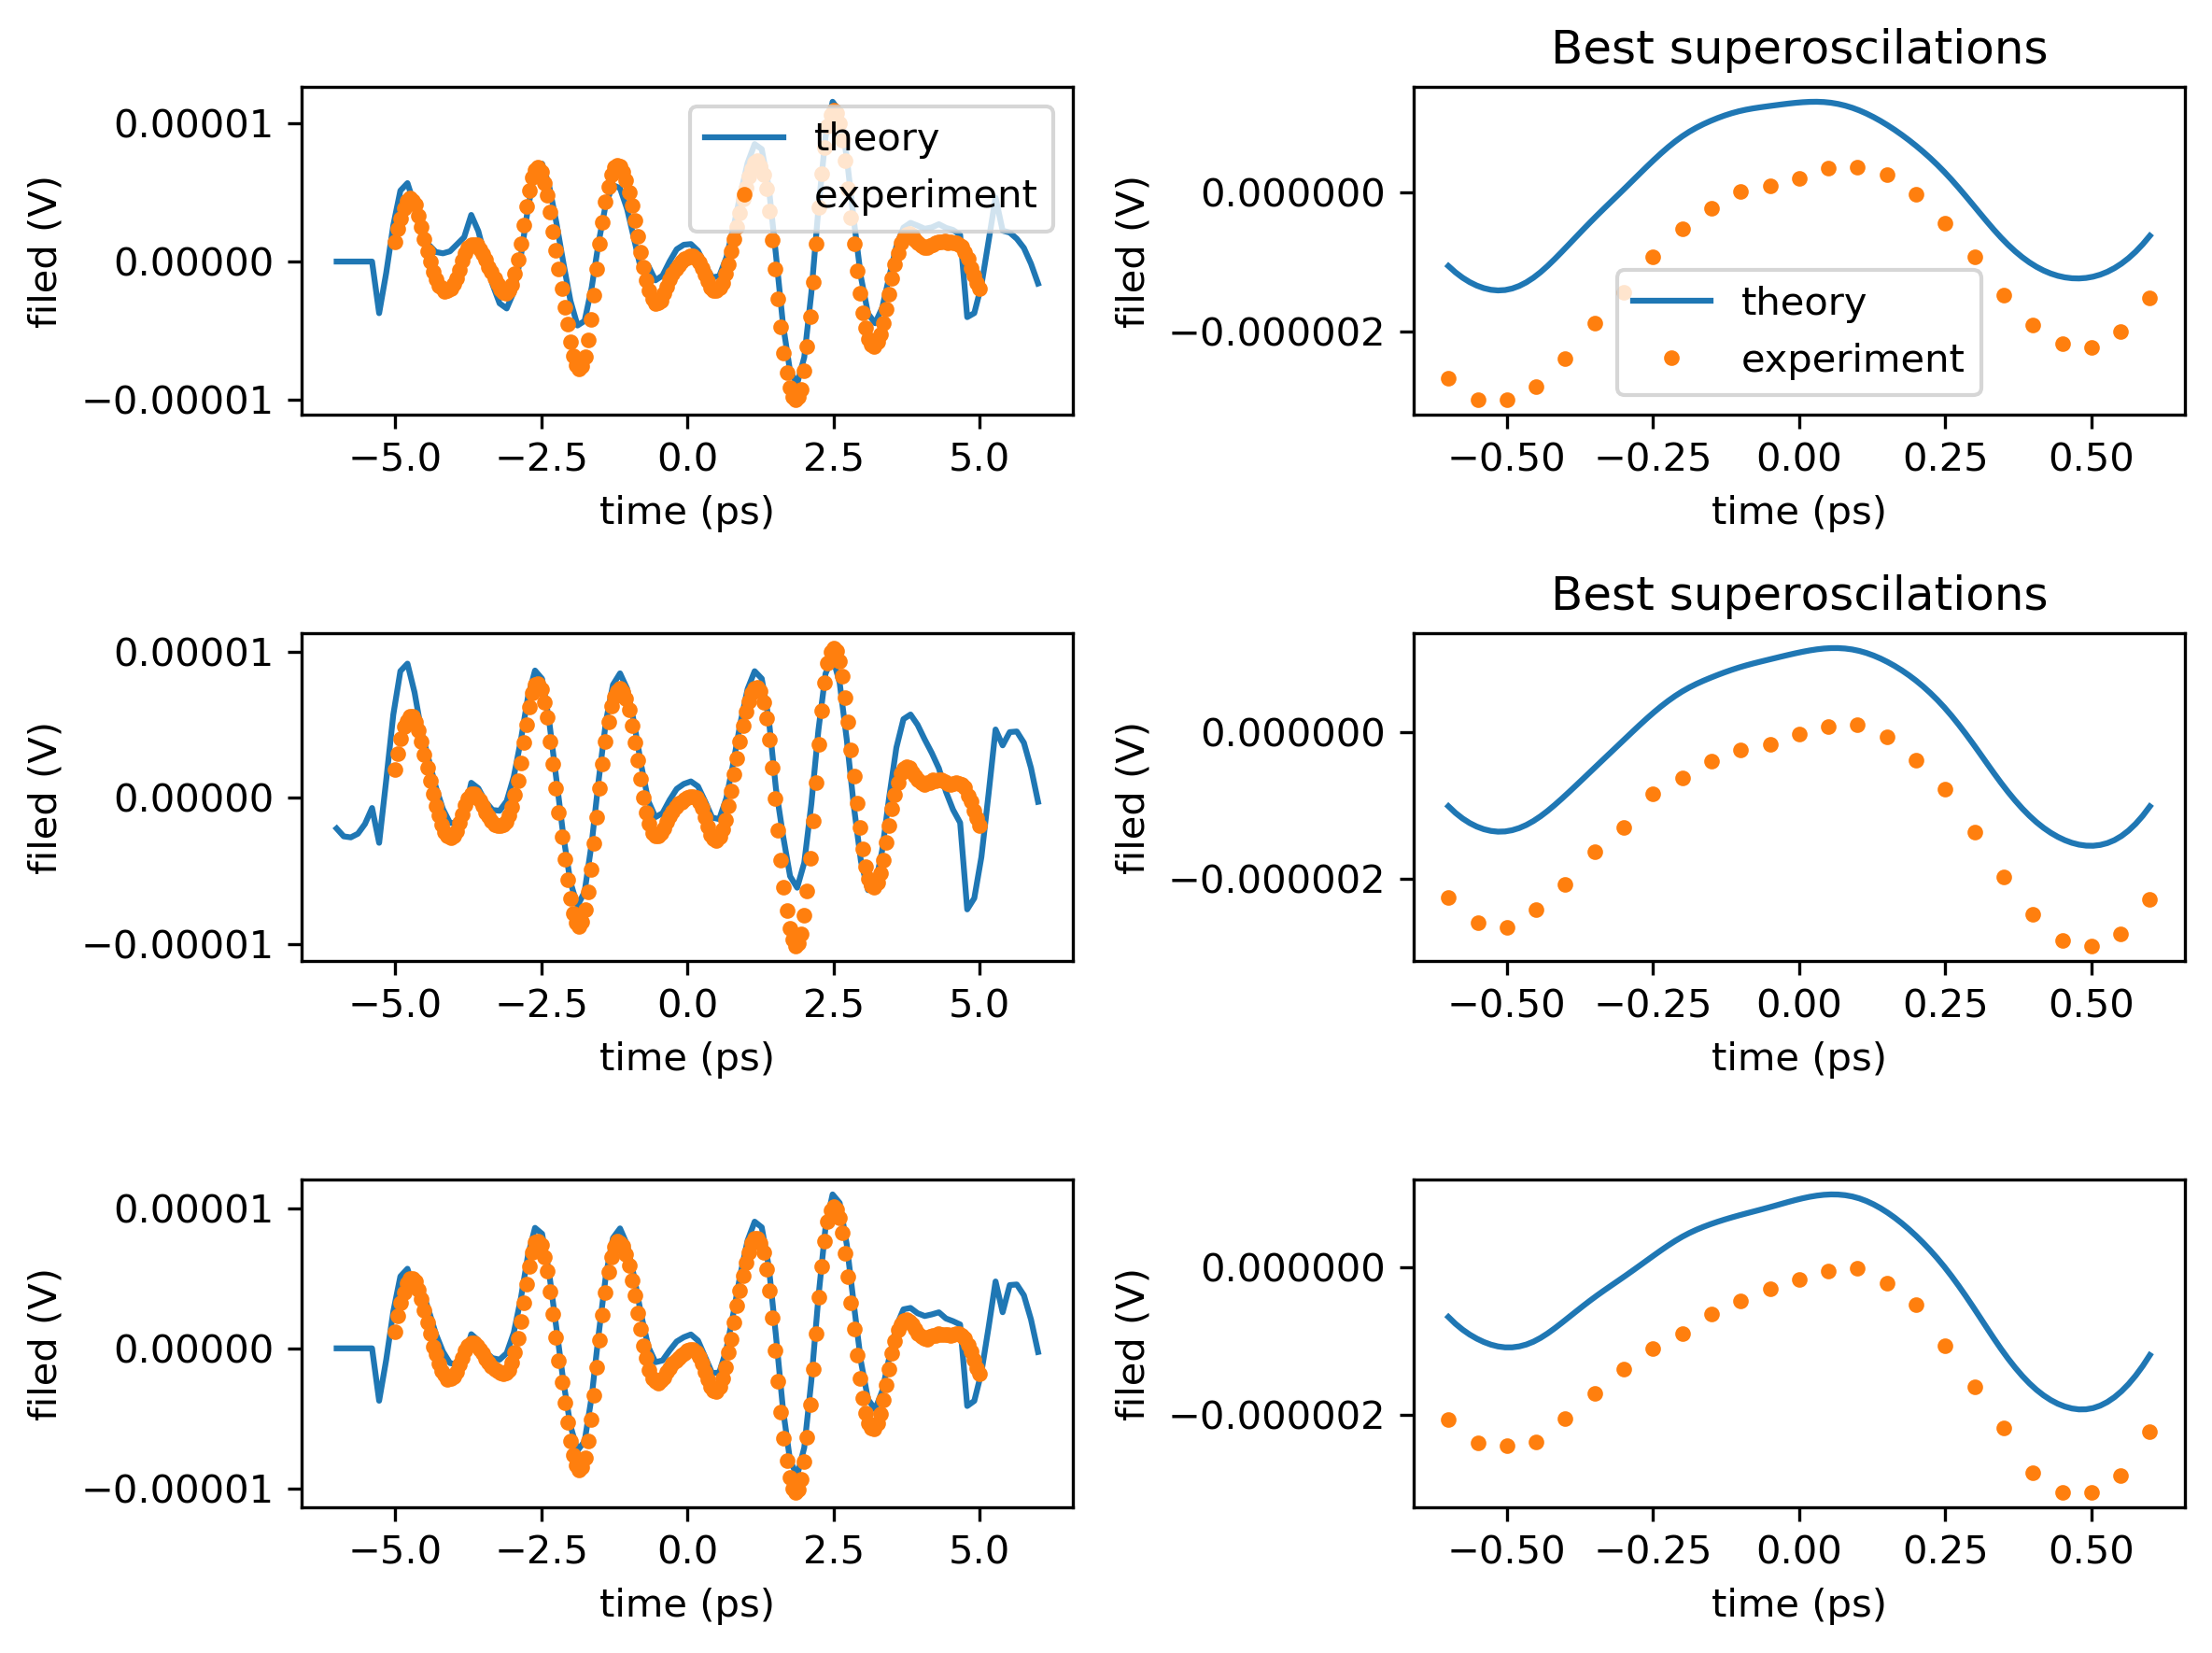

In [26]:
long_time_window = 10 * time_window

data_plotting = list(zip(all_time_delays, long_experimental_so, short_experimental_so))
n_plots = len(data_plotting)

plt.figure(figsize=(8, 2 * n_plots), dpi=300)

for n, (time_delays, long, short,) in enumerate(data_plotting):

    
    plt.title("Best superoscilations")

    plt.subplot(n_plots, 2, 2 * n + 1)

    plt.plot(
        long_time_window, get_combined_field(time_delays, long_time_window), 
        label=(None if n else "theory")
    )

    plt.plot(long.time, long.field, '.', label=(None if n else "experiment"))
    if n == 0:
        plt.legend()

    plt.xlabel('time (ps)')
    plt.ylabel('filed (V)')

    plt.subplot(n_plots, 2, 2 * n + 2)

    plt.plot(
        time_window, 
        get_combined_field(time_delays, time_window), 
        label=(None if n else "theory")
    )
    
    plt.plot(short.time, short.field, '.', label=(None if n else "experiment"))
    if n == 0:
        plt.legend()
        
    plt.xlabel('time (ps)')
    plt.ylabel('filed (V)')
    


plt.tight_layout()
plt.savefig(get_unique_filename("predicted_so_{}.png"))
plt.show()  

In [27]:
all_time_delays[:10]

array([[ 4.25,  1.2 ,  0.35, -0.3 ],
       [-3.4 ,  1.2 ,  0.35, -0.3 ],
       [ 0.45,  1.2 ,  0.35, -0.3 ],
       [ 0.45, -2.  ,  0.35, -0.3 ],
       [ 4.25, -2.  ,  0.35, -0.3 ],
       [-1.5 ,  1.2 ,  0.35, -0.3 ],
       [-3.4 , -2.  ,  0.35, -0.3 ],
       [ 2.4 , -2.  ,  0.35, -0.3 ],
       [ 0.45,  3.55, -1.85,  3.25],
       [ 2.4 , -2.85, -1.85, -0.3 ]])

In [28]:
all_time_delays[:10]

array([[ 4.25,  1.2 ,  0.35, -0.3 ],
       [-3.4 ,  1.2 ,  0.35, -0.3 ],
       [ 0.45,  1.2 ,  0.35, -0.3 ],
       [ 0.45, -2.  ,  0.35, -0.3 ],
       [ 4.25, -2.  ,  0.35, -0.3 ],
       [-1.5 ,  1.2 ,  0.35, -0.3 ],
       [-3.4 , -2.  ,  0.35, -0.3 ],
       [ 2.4 , -2.  ,  0.35, -0.3 ],
       [ 0.45,  3.55, -1.85,  3.25],
       [ 2.4 , -2.85, -1.85, -0.3 ]])

## Get superoscilationsby using time delays and amplitude modulations 

all_time_delays_ampl_modulation = all_time_delays.copy()

with Pool() as pool:
    intensity_ampl_modulation, ampl_values = zip(
        *pool.map(inegral_ampl_modulation, tqdm(all_time_delays_ampl_modulation))
    )

Extract the best candidates for getting superoscilations  

intensity_ampl_modulation = np.array(intensity_ampl_modulation)

# unlike the time delay permutation objective function, we need to multiply by dt to directly compare two
intensity_ampl_modulation *= time_window[1] - time_window[0]

ampl_values = np.array(ampl_values)
ampl_values = ampl_values[indx]

indx = np.argsort(intensity_ampl_modulation)
intensity_ampl_modulation = intensity_ampl_modulation[indx]

all_time_delays_ampl_modulation = all_time_delays_ampl_modulation[indx]

plt.figure(figsize=(5,4), dpi=300)
plt.title("Distribution of superoscilations")
plt.loglog(intensity_ampl_modulation, label="phase and amplitude modulation")
plt.loglog(intensity_without_ampl_modulation, label="phase modulation only")
plt.legend()
plt.xlabel('superoscilation number')
plt.ylabel('Intesnity')
plt.show()

## Is there evidence that amplitude modulation is used (hence, helpful)?

plt.figure(figsize=(5,4), dpi=300)
plt.title("Standard deviation of the amplitude modulations")
plt.loglog(np.std(ampl_values, axis=1))
plt.xlabel('superoscilation number')
plt.ylabel('Standard deviation of the amplitude modulations')
plt.show()

## plot best superoscilations

def get_combined_field_ampl_modulation(time_delays, amplitudes, time_window):
    return sum(
        a * _.interp_field(time_window - delay) for delay, a, _ in zip(time_delays, amplitudes, pulses.values())
    )

plt.figure(figsize=(10,4), dpi=300)
plt.title("Best superoscilations with amplitude modulation")

plt.subplot(121)

long_time_window = 10 * time_window

for n, (time_delays, amplitudes) in enumerate(zip(all_time_delays_ampl_modulation[:5], ampl_values[:5])):
    plt.plot(
        long_time_window, 
        get_combined_field_ampl_modulation(time_delays, amplitudes, long_time_window), 
        label=str(n)
    )

plt.plot(long_time_window, combined_pulse.interp_field(long_time_window), color='black', label='experimental')

plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.legend()

plt.subplot(122)

for n, (time_delays, amplitudes) in enumerate(zip(all_time_delays_ampl_modulation[:5], ampl_values[:5])):
    plt.plot(
        time_window, 
        get_combined_field_ampl_modulation(time_delays, amplitudes, time_window), 
        label=str(n)
    )
    
plt.plot(time_window, combined_pulse.interp_field(time_window), color='black', label='experimental')

plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.legend()


plt.show()  

all_time_delays_ampl_modulation[:10]

ampl_values[:20]